In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
import numba as nb
from numba import jit
from numba import njit
from numba.typed import List
from IPython.display import HTML
from IPython import display
import time

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Input parameters:

# Sample Material: AISI Type 316L Stainless Steel

# Plate Initialization:
x_length = .05;          # [m]
y_length = .05;          # [m]
nx = 350;                # number of grid points (Should be at least 1 per mm)
ny = 350;                # number of grid points

# Plate Properties:
T0 = 300; 			        # Initial ambient temperature [K]
q = 120; 			          # laser power [W]
k = 15; 			          # conductivity coefficient [W/m/K]
cp = .5*1000; 			    # specific heat [J/g/c]-->[J/kg/K]
rho = 8*1000; 		      # density [g/cc]-->[kg/m^3]
Melt_Temp = 1670;       # Melting point of material [k]
Est_Max_Temp = 2500;

# Laser Initialization:
HS_Points =[[-0.015,-.015],[-0.015,0.015],[.015,-0.015],[0.015,0.015]];    # Heat Source Points [x,y], [m]
Speed = 50/1000; 	            # laser speed x [m/s] (from [mm/sec])

# Simulation Options:
Data_points = 400;      # amount of data sets collected
Frames_Used = 100;       # Frames seen (Should evenly devide Data points)
Scale = 1;              # figure window scale
Window_Pos = [0,0];     # Position of window from plate center (x,y) [m]
Temp_sensitivity = 100;  # pecent of maximum temperature shown on figure
Temp_Definition  = 200; # Levels of temperature displayed on figure

In [3]:
#For lazer with point guided path
def Lazer_Path_Point(speed,Data_points,HS_Points):
  total_time=0
  All_times = list();
  All_Distance = list();
  All_dx_dt = list();
  All_dy_dt = list();
  for p in range(len(HS_Points)-1):
    Point = HS_Points[p];
    Next_Point = HS_Points[p+1];
    dx = Next_Point[0]-Point[0];
    dy = Next_Point[1]-Point[1];
    Dist_Covered = np.sqrt((dx)**2+(dy)**2);
    time_elap = Dist_Covered/speed;
    dx_dt = dx/time_elap;
    dy_dt = dy/time_elap;
    All_Distance.append(Dist_Covered);
    All_times.append(time_elap);
    All_dx_dt.append(dx_dt);
    All_dy_dt.append(dy_dt);
  total_Time = sum(All_times);
  Sim_dt = total_Time/Data_points;
  step = 1;
  current_path = 0;
  time_elap = 0;
  xq_pre = HS_Points[0][0];
  yq_pre = HS_Points[0][1];
  All_xq_pos = np.array([xq_pre]);
  All_yq_pos = np.array([yq_pre]);
  while step <Data_points:
    path_time = All_times[current_path]
    time_elap = time_elap + Sim_dt;
    if time_elap >= path_time:
      current_path = current_path +1;
      time_elap = 0;
    for path in range(np.size(HS_Points)-1):
      if path == current_path:
        xq_pos = xq_pre + All_dx_dt[path]*Sim_dt;
        yq_pos = yq_pre + All_dy_dt[path]*Sim_dt;
        All_xq_pos = np.concatenate((All_xq_pos,np.array([xq_pos])));
        All_yq_pos = np.concatenate((All_yq_pos,np.array([yq_pos])));
    xq_pre = xq_pos;
    yq_pre = yq_pos;
    step = step+1;
  return total_Time,Sim_dt,All_xq_pos,All_yq_pos

In [4]:
[x,y] = np.meshgrid(np.linspace(-x_length/2,x_length/2,nx),np.linspace(-y_length/2,y_length/2,ny)); # [m]
Max_Time,dt,xq_pos,yq_pos = Lazer_Path_Point(Speed,Data_points,HS_Points);
alpha = k/(rho*cp);
area = (x_length/nx)**2
diff_coeff = (alpha*dt)/(area);
Time = np.linspace(0,Max_Time,Data_points);

Time_list = list(Time)

Trial_Bound_x = List();
Trial_Bound_y = List();

T = T0*np.ones((nx,ny));
T0_Mat = T0*np.ones((nx,ny));

In [5]:
#Functions needed to complete calculations
@jit('(float64[:,:])(int64,int64,float64,float64[:,:],float64[:,:])',nopython=True)
def Diffusion(nx,ny,diff_coeff,T_pre,T):
  diff_new = T;
  for i in range(1,nx-1,1):
    for j in range(1,ny-1,1):     # gauss seidel iteration
      diff_new[i][j]=(T_pre[i][j]+diff_coeff*(T[i-1][j]+T[i+1][j]+T[i][j-1]+T[i][j+1]))/(1+4*diff_coeff);
  return diff_new

@jit('(float64[:,:])(int64,int64,int64,float64,float64,float64,float64,float64[:],float64[:],float64[:,:])',nopython=True)
def Heat_Dist(nx,ny,t,k,rho,cp,dt,xq_pos,yq_pos,T_diff):
  T_new = T_diff;
  for i in range(1,nx-1,1):
    for j in range(1,ny-1,1):
      A = (rho*cp)**(1/2);
      B = 8*((np.pi*k*dt)**(3/2));
      C = (rho*cp)/(4*k*dt);
      D = ((x[i][j]-xq_pos[t-1])**2)+((y[i][j]-yq_pos[t-1]))**2;
      Q = q*dt; #Laser strength [J]
      T_new[i][j] = T_diff[i][j] + ((Q*A)/B)*np.exp(-C*D);
  return T_new
@jit('(float64,float64[:,:],float64[:,:],float64[:,:])',nopython=True)
def Melt_Bound(Melt_Temp,T,x,y):
  Bound_x = [np.float64(x) for x in range(0)];
  Bound_y = [np.float64(x) for x in range(0)];
  for i in range(1,nx-1,1):
    for j in range(1,ny-1,1):
      if T[i][j]>Melt_Temp and T[i][j]<Melt_Temp*1.05:
        Bound_x.append(x[i][j])
        Bound_y.append(y[i][j])
  Bound_x = np.array(Bound_x)
  Bound_y = np.array(Bound_y)
  return Bound_x,Bound_y

In [6]:
# Functions for Plotting:
# Temperature Contour
n = int(Data_points/Frames_Used);
def initialize_Contour(T0,q,k,cp,rho,T_Max,Temp_sensitivity,Temp_Definition,x_length,y_length,Window_Pos,Scale):
  fig_Contour,axc = plt.subplots(1,1)
  plt.rcParams.update({'text.color': "Black"})
  axc.set_title('Temperature Contour')
  axc.set_xlabel('X [m]')
  axc.set_ylabel('Y [m]')
  axc.set_xlim((-((x_length/2)+Window_Pos[0])*Scale, ((x_length/2)+Window_Pos[0])*Scale));
  axc.set_ylim((-((y_length/2)+Window_Pos[1])*Scale, ((y_length/2)+Window_Pos[1])*Scale));
  plt.rcParams.update({'text.color': "white"})
  #ax.text(0.01, 0.95,['v(x,y)= ', (str(vx),str(vy))], transform=ax.transAxes,fontsize=8);
  axc.text(0.01, 0.91,['T0= ', str(T0)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.87,['q= ', str(q)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.83,['k= ', str(k)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.79,['cp= ', str(cp)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.75,['rho= ', str(rho)], transform=axc.transAxes,fontsize=8);
  plt.rcParams.update({'text.color': "Black"})
  cvals = np.linspace(T0,T_Max*(Temp_sensitivity/100),Temp_Definition)     # set contour values
  return fig_Contour,axc,cvals
@jit(forceobj=True)
def plt_Contour(Time,t,axc,x,y,T,cvals,fig_Contour,*,hdisplay):
  axc.set_title(['Weld Puddle: Time Elapsed- ',str(round(Time[t],2))])
  T_cont = axc.contourf(x, y, T, cvals,cmap = cm.jet)
  if t == 0:
    plt.colorbar(T_cont)
  hdisplay.update(fig_Contour)
  return T_cont

# Weld Puddle
def initialize_Puddle(x_length,y_length,Window_Pos,Scale):
  fig_Bound,axp = plt.subplots(1,1)

  plt.rcParams.update({'text.color': "Black"})
  axp.set_title('Weld Puddle')
  axp.set_xlabel('X [m]')
  axp.set_ylabel('Y [m]')
  axp.set_xlim((-((x_length/2)+Window_Pos[0])*Scale, ((x_length/2)+Window_Pos[0])*Scale));
  axp.set_ylim((-((y_length/2)+Window_Pos[1])*Scale, ((y_length/2)+Window_Pos[1])*Scale));
  return fig_Bound,axp
@jit(forceobj=True)
def plt_Bound(Time,t,axp,P_x,P_y,fig_Bound, *,hdisplay):
    axp.set_title(['Weld Puddle: Time Elapsed- ',str(round(Time[t],2))])
    Puddle = axp.scatter(P_x, P_y,c='red');
    hdisplay.update(fig_Bound)
    return Puddle

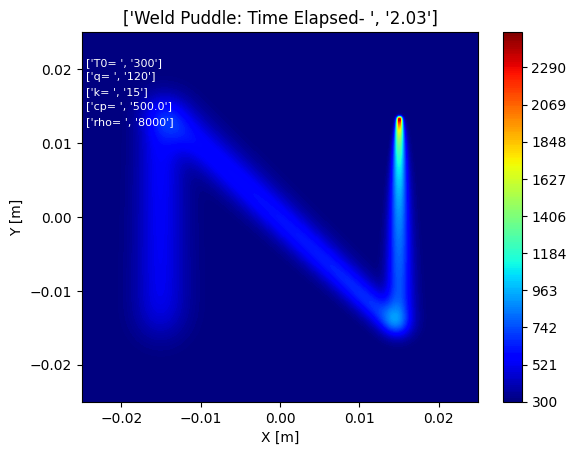

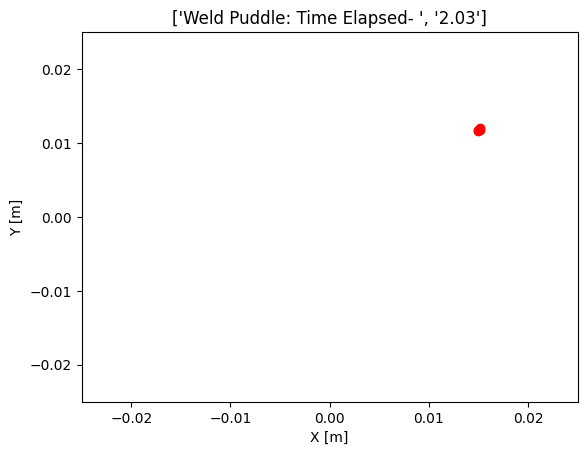

In [7]:
fig_Contour,axc,cvals = initialize_Contour(T0,q,k,cp,rho,Est_Max_Temp,Temp_sensitivity,Temp_Definition,x_length,y_length,Window_Pos,Scale)
hdisplay_Cont = display.display("Contour", display_id=True);
fig_Bound,axp = initialize_Puddle(x_length,y_length,Window_Pos,Scale)
hdisplay_Bound = display.display("Puddle", display_id=True);
for t in range(Data_points):
  T_pre = T;
  X_Bounds,Y_Bounds = Melt_Bound(Melt_Temp,T,x,y,)
  if t % n == 0:
    T_Cont = plt_Contour(Time,t,axc,x,y,T,cvals,fig_Contour,hdisplay=hdisplay_Cont)
    Puddle = plt_Bound(Time,t,axp,X_Bounds,Y_Bounds,fig_Bound,hdisplay=hdisplay_Bound)
    Puddle.remove()
    time.sleep(.0001)
    T_Cont.remove()

  T_diff = Diffusion(nx,ny,diff_coeff,T_pre,T)

  T = Heat_Dist(nx,ny,t,k,rho,cp,dt,xq_pos,yq_pos,T_diff)

plt.close(fig_Bound)
plt.close(fig_Contour)